In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pylab as plt
import seaborn as sns
import pandas as pd
import imblearn
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [3]:
Beans = pd.read_excel('DryBeanDataSet.xlsx')
Beans.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,Constantness,EquivDiameter,Colour,...,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,ShapeFactor5,ShapeFactor6,Class,Sort order
0,84648,1132.054,439.915710,248.961941,1.767000,0.824453,86779,1,328.294351,brown,...,0.830027,0.746266,0.005197,0.000994,0.556914,3.487008,0.984066,50.809833,CALI,0.134791
1,39704,736.873,271.659919,186.481404,1.456767,0.727175,40106,1,224.839282,black,...,0.918880,0.82765,0.006842,0.001980,0.685004,1.242335,0.997891,148.508874,DERMASON,0.898848
2,35835,687.914,237.704180,192.176759,1.236904,0.588537,36190,1,213.603696,green,...,0.951588,0.898611,0.006633,0.002668,0.807503,2.813489,0.998803,82.107117,SEKER,0.539684
3,223035,1817.278,680.812555,419.994347,1.621004,0.787040,225889,1,532.894907,brown,...,0.848673,0.782734,0.003052,0.000707,0.612672,3.074472,0.993144,147.347735,BOMBAY,0.149130
4,41957,767.143,287.962974,186.166695,1.546802,0.762918,42310,1,231.130508,brown,...,0.895904,0.80264,0.006863,0.001757,0.644230,2.213954,0.996497,22.893826,SIRA,0.447635


In [4]:
Beans["Colour"] = Beans["Colour"].astype('category')
Beans["Constantness"] = pd.to_numeric(Beans["Constantness"], errors='coerce')
Beans["Class"] = Beans["Class"].astype('category')
Beans["Extent"] = pd.to_numeric(Beans["Extent"], errors='coerce')
Beans["Compactness"] = pd.to_numeric(Beans["Compactness"], errors='coerce')
Beans["ShapeFactor6"] = pd.to_numeric(Beans["ShapeFactor6"], errors='coerce')
Beans["Class"].replace('?', np.nan, inplace=True)
Beans["Colour"].replace('?', np.nan, inplace=True)

In [5]:
Beans.isna().sum()

Area                0
Perimeter           0
MajorAxisLength     0
MinorAxisLength     0
AspectRation        0
Eccentricity        0
ConvexArea          0
Constantness        0
EquivDiameter       0
Colour              6
Extent              6
Solidity            0
roundness           0
Compactness        18
ShapeFactor1        0
ShapeFactor2        0
ShapeFactor3        0
ShapeFactor4        0
ShapeFactor5        0
ShapeFactor6        5
Class              17
Sort order          0
dtype: int64

In [6]:
Beans.dtypes

Area                  int64
Perimeter           float64
MajorAxisLength     float64
MinorAxisLength     float64
AspectRation        float64
Eccentricity        float64
ConvexArea            int64
Constantness          int64
EquivDiameter       float64
Colour             category
Extent              float64
Solidity            float64
roundness           float64
Compactness         float64
ShapeFactor1        float64
ShapeFactor2        float64
ShapeFactor3        float64
ShapeFactor4        float64
ShapeFactor5        float64
ShapeFactor6        float64
Class              category
Sort order          float64
dtype: object

In [7]:
mask = Beans['Colour'].isna()
Beans_encoded = pd.get_dummies(Beans, columns=['Colour'], dtype=float)
Beans_encoded.iloc[mask, Beans_encoded.columns.str.startswith('Colour_')] = np.nan
Beans_encoded.isna().sum()

Area                0
Perimeter           0
MajorAxisLength     0
MinorAxisLength     0
AspectRation        0
Eccentricity        0
ConvexArea          0
Constantness        0
EquivDiameter       0
Extent              6
Solidity            0
roundness           0
Compactness        18
ShapeFactor1        0
ShapeFactor2        0
ShapeFactor3        0
ShapeFactor4        0
ShapeFactor5        0
ShapeFactor6        5
Class              17
Sort order          0
Colour_black        6
Colour_brown        6
Colour_green        6
Colour_white        6
dtype: int64

In [8]:
Beans_encoded = Beans_encoded.drop([2762, 3941, 4780, 5884])
Beans_encoded = Beans_encoded.reset_index(drop=True)

## Resample the data set and then apply normalization.

In [9]:
Beans_missing = Beans_encoded[Beans_encoded.isna().any(axis=1)]
Beans_missing.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,Constantness,EquivDiameter,Extent,...,ShapeFactor3,ShapeFactor4,ShapeFactor5,ShapeFactor6,Class,Sort order,Colour_black,Colour_brown,Colour_green,Colour_white
6,44787,861.814,344.333903,166.179732,2.072057,0.875834,45406,1,238.798198,0.812920,...,0.480953,1.522022,0.996562,25.541389,NaN,0.678889,0.0,1.0,0.0,0.0
104,48479,836.757,312.354576,199.059288,1.569153,0.770627,49080,0,248.445930,0.678398,...,0.632657,2.705577,0.992735,99.847826,SIRA,0.923518,0.0,1.0,0.0,0.0
118,42432,776.089,290.071712,187.172173,1.549759,0.763962,42908,1,232.435153,0.756957,...,0.642086,1.117294,0.995078,126.833659,NaN,0.770406,0.0,1.0,0.0,0.0
436,41708,775.920,292.968805,181.913240,1.610486,0.783866,42212,1,230.443648,0.689218,...,0.618709,2.961417,0.996423,111.802204,NaN,0.729772,0.0,1.0,0.0,0.0
484,76489,1079.856,423.766238,234.103967,1.810163,0.833555,78182,0,312.071818,0.680053,...,0.542321,2.856135,0.981689,103.156493,CALI,0.942229,0.0,1.0,0.0,0.0


In [10]:
Beans_encoded = Beans_encoded.dropna()
Beans_encoded = Beans_encoded.reset_index(drop=True)
Beans_encoded

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,Constantness,EquivDiameter,Extent,...,ShapeFactor3,ShapeFactor4,ShapeFactor5,ShapeFactor6,Class,Sort order,Colour_black,Colour_brown,Colour_green,Colour_white
0,84648,1132.054,439.915710,248.961941,1.767000,0.824453,86779,1,328.294351,0.767184,...,0.556914,3.487008,0.984066,50.809833,CALI,0.134791,0.0,1.0,0.0,0.0
1,39704,736.873,271.659919,186.481404,1.456767,0.727175,40106,1,224.839282,0.757739,...,0.685004,1.242335,0.997891,148.508874,DERMASON,0.898848,1.0,0.0,0.0,0.0
2,35835,687.914,237.704180,192.176759,1.236904,0.588537,36190,1,213.603696,0.790885,...,0.807503,2.813489,0.998803,82.107117,SEKER,0.539684,0.0,0.0,1.0,0.0
3,223035,1817.278,680.812555,419.994347,1.621004,0.787040,225889,1,532.894907,0.761092,...,0.612672,3.074472,0.993144,147.347735,BOMBAY,0.149130,0.0,1.0,0.0,0.0
4,41957,767.143,287.962974,186.166695,1.546802,0.762918,42310,1,231.130508,0.721543,...,0.644230,2.213954,0.996497,22.893826,SIRA,0.447635,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13550,23018,578.382,203.761000,144.297607,1.412089,0.706041,23465,1,171.194123,0.781994,...,0.705888,2.197446,0.996776,85.821969,DERMASON,0.764478,1.0,0.0,0.0,0.0
13551,69773,1095.057,387.116310,231.153291,1.674717,0.802155,71055,1,298.056610,0.762446,...,0.592809,1.004792,0.992787,152.980591,BARBUNYA,0.679735,0.0,1.0,0.0,0.0
13552,55773,968.988,347.920243,204.491191,1.701395,0.809040,57047,0,266.481499,0.765377,...,0.586644,2.219590,0.998113,102.437378,BARBUNYA,0.946849,0.0,1.0,0.0,0.0
13553,64235,1005.875,409.304636,201.686606,2.029409,0.870169,65018,1,285.983465,0.773990,...,0.488190,2.078504,0.990736,174.754039,HOROZ,0.046135,0.0,0.0,0.0,1.0


In [142]:
X = Beans_encoded.drop(['Sort order', 'Class'], axis = 1)
y = Beans_encoded['Class']

smote = SMOTE(random_state=42)
tomek = TomekLinks()

pipeline = Pipeline(steps=[('tomek', tomek), ('smote', smote)])

X_resampled, y_resampled = pipeline.fit_resample(X,np.asarray(y))

X_beans = pd.concat([X_resampled, Beans_missing.drop(['Sort order', 'Class'], axis = 1)])
y_beans = pd.concat([pd.Series(y_resampled), pd.Series(Beans_missing['Class'])])
X_beans = X_beans.reset_index(drop=True)
y_beans = y_beans.reset_index(drop=True)

In [77]:
X_cat = X[["Constantness", "Colour_black", "Colour_brown", "Colour_green", "Colour_white"]]
X_num = X.drop(["Constantness", "Colour_black", "Colour_brown", "Colour_green", "Colour_white"], axis=1)

X_standard = (X_num-X_num.mean())/X_num.std()
X_beans = pd.concat([X_standard, X_cat], axis=1)
y_beans = np.asarray(y)

In [143]:
X_cat = X_beans[["Constantness", "Colour_black", "Colour_brown", "Colour_green", "Colour_white"]]
X_num = X_beans.drop(["Constantness", "Colour_black", "Colour_brown", "Colour_green", "Colour_white"], axis=1)

X_standard = (X_num-X_num.mean())/X_num.std()
X_beans = pd.concat([X_standard, X_cat], axis=1)

In [144]:
y_beans = pd.Series(y_beans, name="Class")
Big_beans = pd.concat([X_beans, y_beans], axis=1)
X_missing = Big_beans[Big_beans["Class"].isna()]
X_missing = X_missing.drop(["Class"],axis=1)

Cleaned_beans = Big_beans.dropna(subset=["Class"])
X_cleaned = Cleaned_beans.drop(["Class"], axis=1)
y_cleaned = Cleaned_beans["Class"]

Beans_df = Cleaned_beans.dropna()
X_subset = Beans_df.drop(["Class"], axis=1)
y_subset = Beans_df["Class"]

class_mapping = {
    "DERMASON": 0,
    "SEKER": 1,
    "BOMBAY": 2,
    "CALI": 3,
    "SIRA": 4,
    "HOROZ": 5,
    "BARBUNYA": 6
}

# Relabel the classes in y_subset
y_subset = y_subset.replace(class_mapping)

In [182]:
import warnings
from sklearn.exceptions import DataConversionWarning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
# Suppress the specific warning
warnings.filterwarnings("ignore", message="X does not have valid feature names")

Beans_subset = X_subset.copy()
best_subset = []
n = X_beans.shape[1]-1

while n != 0:
    RSS = np.inf
    curr_subset = None
    for i in Beans_subset.columns:
        temp_subset = Beans_subset.drop(i, axis=1)

        X_train, X_test, y_train, y_test = train_test_split(temp_subset, y_subset, test_size=0.2, random_state=1)

        knn_subset = KNeighborsClassifier(n_neighbors=135, weights="uniform")
        knn_subset.fit(X_train, y_train)

        y_pred = knn_subset.predict(np.asarray(X_test))

        temp_rss = ((y_test-y_pred)**2).sum()
        if temp_rss < RSS:
            RSS = temp_rss
            curr_subset = temp_subset
    best_subset.append(curr_subset)
    Beans_subset = curr_subset
    n -= 1

In [183]:
best_subset

[           Area  Perimeter  MajorAxisLength  MinorAxisLength  AspectRation  \
 0     -0.654939  -0.790228        -0.797362        -0.615384     -0.581271   
 1     -0.739157  -0.955827        -1.094012        -0.529998     -1.476344   
 2      3.335741   2.864146         2.777144         2.885483      0.087348   
 3     -0.765366  -1.016352        -1.167112        -0.526630     -1.659271   
 4     -0.802153  -0.931153        -0.941845        -0.942209     -0.205046   
 ...         ...        ...              ...              ...           ...   
 22423 -0.415495  -0.399249        -0.346196        -0.406379      0.059215   
 22424 -0.530101  -0.553827        -0.449921        -0.609149      0.273842   
 22425 -0.761600  -0.841762        -0.929973        -0.812617     -0.475811   
 22426 -0.595731  -0.664021        -0.678212        -0.564531     -0.394410   
 22427 -0.470610  -0.510088        -0.513192        -0.378218     -0.388801   
 
        Eccentricity  ConvexArea  EquivDiameter   

In [184]:
mean_scores = []
std_scores = []
for i in range(1, len(best_subset)):

    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    model = KNeighborsClassifier(n_neighbors=135,weights="uniform")

    score = cross_val_score(model, np.asarray(X_subset[best_subset[i].columns]), y_subset, cv=kf, scoring='accuracy')
    mean_score = score.mean()
    std_score = score.std()
    
    mean_scores.append(mean_score)
    std_scores.append(std_score)

In [185]:
std_scores

[0.002646933814694463,
 0.0029788995951703697,
 0.002670698446707852,
 0.0025873249410219906,
 0.0026914498532297393,
 0.0024109993245305487,
 0.0020329453669982165,
 0.002093531356275149,
 0.0018646875225038291,
 0.002694905902631485,
 0.002297065036963455,
 0.002534817361913586,
 0.002377985470907339,
 0.0023232877603917216,
 0.002390654548569682,
 0.0031176975499907574,
 0.00384776436776153,
 0.004162141600147473,
 0.005731220448550133,
 0.006025231270033501,
 0.010752100981028103]

In [186]:
mean_cv_errors = []
std_errors = []

for i in range(len(mean_scores)):
    std_error = std_scores[i] / np.sqrt(5)
    mean_cv_error = 1 - mean_scores[i]
    mean_cv_errors.append(mean_cv_error)
    std_errors.append(std_error)

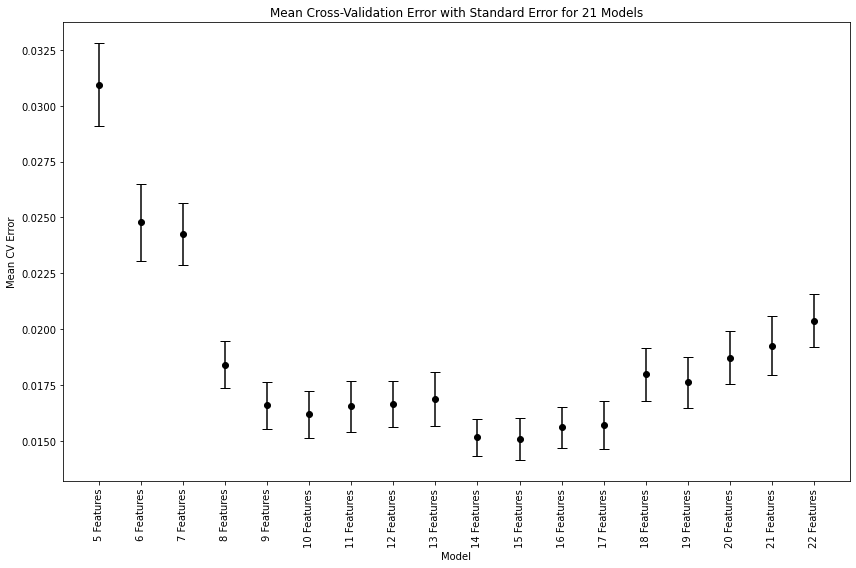

In [187]:
models = [f'{i+5} Features' for i in range(18)]
mean_cv_errors_reversed = mean_cv_errors[0:18][::-1]
std_errors_reversed = std_errors[0:18][::-1]

plt.figure(figsize=(12, 8))
plt.errorbar(models, mean_cv_errors_reversed, yerr=std_errors_reversed, fmt='o', ecolor='black', capsize=5, label='Mean CV Error',  markerfacecolor='black', markeredgecolor = 'black')
plt.xticks(rotation=90)
plt.xlabel('Model')
plt.ylabel('Mean CV Error')
plt.title('Mean Cross-Validation Error with Standard Error for 21 Models')
# plt.grid(True)
plt.tight_layout()
plt.show()

In [192]:
best_beans = best_subset[8]
best_beans

,Area,Perimeter,MinorAxisLength,AspectRation,ConvexArea,EquivDiameter,roundness,ShapeFactor1,ShapeFactor2,ShapeFactor5,Colour_black,Colour_brown,Colour_green,Colour_white
0,-0.654939,-0.790228,-0.615384,-0.581271,-0.657906,-0.717037,0.932778,0.600783,0.704202,0.774447,1.0,0.0,0.0,0.0
1,-0.739157,-0.955827,-0.529998,-1.476344,-0.741992,-0.849320,1.481964,0.449107,1.810454,0.984099,0.0,0.0,1.0,0.0
2,3.335741,2.864146,2.885483,0.087348,3.331283,2.909893,-0.246050,-2.151628,-1.344749,-0.317411,0.0,1.0,0.0,0.0
3,-0.765366,-1.016352,-0.526630,-1.659271,-0.768553,-0.891929,1.780901,0.441119,2.137033,1.096974,0.0,0.0,1.0,0.0
4,-0.802153,-0.931153,-0.942209,-0.205046,-0.800718,-0.953008,-0.115003,1.256401,0.709608,0.864577,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22423,-0.415495,-0.399249,-0.406379,0.059215,-0.416879,-0.372708,0.227461,0.262379,-0.063615,0.484772,0.0,1.0,0.0,0.0
22424,-0.530101,-0.553827,-0.609149,0.273842,-0.530532,-0.532287,0.236555,0.609214,-0.059085,-0.087458,0.0,1.0,0.0,0.0
22425,-0.761600,-0.841762,-0.812617,-0.475811,-0.760071,-0.885738,-0.391031,0.983339,0.857176,0.764136,0.0,1.0,0.0,0.0
22426,-0.595731,-0.664021,-0.564531,-0.394410,-0.599115,-0.627856,0.439252,0.515639,0.457763,0.611276,0.0,1.0,0.0,0.0


In [193]:
from sklearn.model_selection import GridSearchCV

k = 5

clf = GridSearchCV(KNeighborsClassifier(weights="uniform", n_jobs=-1), {
    'n_neighbors': list(range(85, 185, 2))
}, cv=k, return_train_score=False)

clf.fit(best_beans, y_subset)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_jobs=-1),
             param_grid={'n_neighbors': [85, 87, 89, 91, 93, 95, 97, 99, 101,
                                         103, 105, 107, 109, 111, 113, 115, 117,
                                         119, 121, 123, 125, 127, 129, 131, 133,
                                         135, 137, 139, 141, 143, ...]})

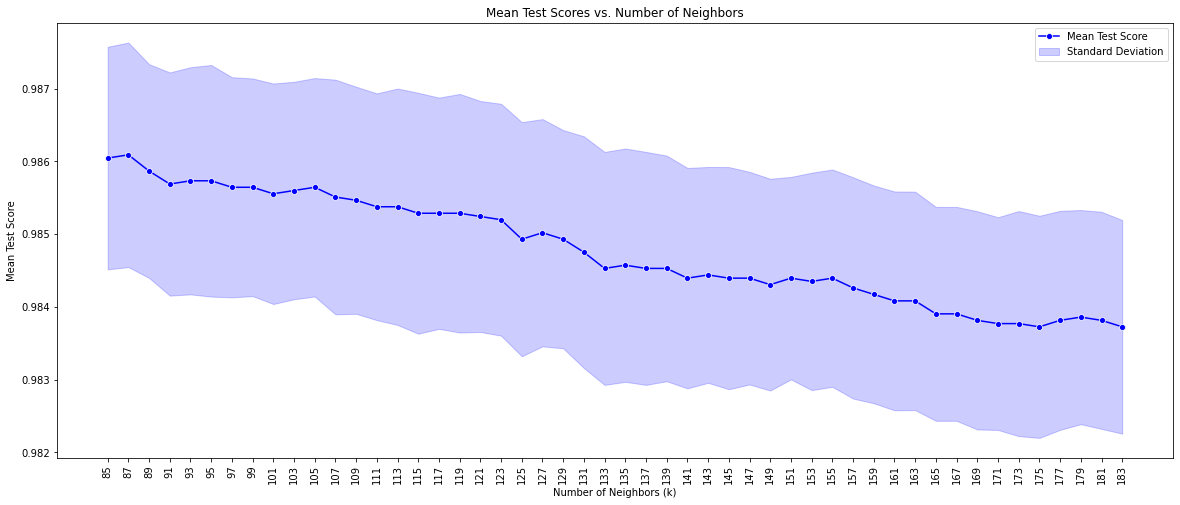

In [194]:
plt.figure(figsize=(20, 8))
sns.lineplot(x=clf.param_grid['n_neighbors'], y=clf.cv_results_['mean_test_score'], marker='o', label='Mean Test Score', color='blue')
plt.fill_between(clf.param_grid['n_neighbors'], 
                 [m - s for m, s in zip(clf.cv_results_['mean_test_score'], clf.cv_results_['std_test_score']/np.sqrt(k))], 
                 [m + s for m, s in zip(clf.cv_results_['mean_test_score'], clf.cv_results_['std_test_score']/np.sqrt(k))], 
                 color='blue', alpha=0.2, label='Standard Deviation')

plt.title('Mean Test Scores vs. Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Test Score')
plt.xticks(rotation=90)
plt.xticks(clf.param_grid['n_neighbors'])
# plt.grid(True)
plt.legend()
plt.show()

In [159]:
plt.figure(figsize=(20, 8))
sns.lineplot(x=clf.param_grid['n_neighbors'], y=clf.cv_results_['mean_train_score'], marker='o', label='Mean Train Score', color='blue')
plt.fill_between(clf.param_grid['n_neighbors'], 
                 [m - s for m, s in zip(clf.cv_results_['mean_train_score'], clf.cv_results_['std_train_score']/np.sqrt(k))], 
                 [m + s for m, s in zip(clf.cv_results_['mean_train_score'], clf.cv_results_['std_train_score']/np.sqrt(k))], 
                 color='blue', alpha=0.2, label='Standard Deviation')

plt.title('Mean Test Scores vs. Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Test Score')
plt.xticks(rotation=90)
plt.xticks(clf.param_grid['n_neighbors'])
# plt.grid(True)
plt.legend()
plt.show()

KeyError: 'mean_train_score'

<Figure size 1440x576 with 0 Axes>

In [200]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import ttest_rel

# Sample data (X, y) and classifier
# X, y = ...  # Your datase
n_neighbors = list(range(85,185,2))
for i in n_neighbors:
    k1, k2 = i, i+2  # Two k values to compare

    # Perform cross-validation for both k values
    knn_k1 = KNeighborsClassifier(n_neighbors=k1, weights="uniform")
    knn_k2 = KNeighborsClassifier(n_neighbors=k2, weights="uniform")

    scores_k1 = cross_val_score(knn_k1, best_beans, y_subset, cv=5)
    scores_k2 = cross_val_score(knn_k2, best_beans, y_subset, cv=5)

    # Perform paired t-test
    stat, p_value = ttest_rel(scores_k1, scores_k2)

    if p_value < 0.05:
        print(f"Paired t-test p-value: {p_value}")
        print(f"Has statistically significant difference between {k1} and {k2}.")

Paired t-test p-value: 0.0038798942545107875
Has statistically significant difference between 123 and 125.
Paired t-test p-value: 0.03411865384612896
Has statistically significant difference between 131 and 133.
Paired t-test p-value: 0.01613009156716526
Has statistically significant difference between 163 and 165.


In [203]:
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

knn1 = KNeighborsClassifier(n_neighbors=125,weights="uniform")
knn2 = KNeighborsClassifier(n_neighbors=133,weights="uniform")
knn3 = KNeighborsClassifier(n_neighbors=163,weights="uniform")

class_mapping = {
    0: "DERMASON",
    1: "SEKER",
    2: "BOMBAY",
    3: "CALI",
    4: "SIRA",
    5: "HOROZ",
    6: "BARBUNYA"
}

# Relabel the classes in y_subset
y_subset = y_subset.replace(class_mapping)

X_train, X_test, y_train, y_test = train_test_split(best_beans, y_subset, test_size=0.2, random_state=42)

knn1.fit(X_train, y_train)
knn2.fit(X_train, y_train)
knn3.fit(X_train, y_train)

y_pred1 = knn1.predict(X_test)
y_pred2 = knn2.predict(X_test)
y_pred3 = knn3.predict(X_test)

print('Classification Report for knn 1:')
print(classification_report(y_test, y_pred1))
print('Classification Report for knn 2:')
print(classification_report(y_test, y_pred2))
print('Classification Report for knn 3:')
print(classification_report(y_test, y_pred3))

Classification Report for knn 1:
              precision    recall  f1-score   support

    BARBUNYA       0.97      0.94      0.95       651
      BOMBAY       1.00      1.00      1.00       639
        CALI       0.95      0.97      0.96       634
    DERMASON       1.00      1.00      1.00       629
       HOROZ       1.00      1.00      1.00       655
       SEKER       1.00      0.99      1.00       635
        SIRA       0.97      0.99      0.98       643

    accuracy                           0.98      4486
   macro avg       0.98      0.98      0.98      4486
weighted avg       0.98      0.98      0.98      4486

Classification Report for knn 2:
              precision    recall  f1-score   support

    BARBUNYA       0.97      0.94      0.95       651
      BOMBAY       1.00      1.00      1.00       639
        CALI       0.95      0.97      0.96       634
    DERMASON       1.00      1.00      1.00       629
       HOROZ       1.00      1.00      1.00       655
       SEKER

In [212]:
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from MyKNN import KNN

knn1 = KNN(n_neighbors=125)
knn2 = KNN(n_neighbors=133)
knn3 = KNN(n_neighbors=163)

X_train, X_test, y_train, y_test = train_test_split(X_cleaned[best_beans.columns], y_cleaned, test_size=0.2, random_state=0)

knn1.fit(X_train, y_train)
knn2.fit(X_train, y_train)
knn3.fit(X_train, y_train)

y_pred1 = knn1.predict(np.asarray(X_test))
y_pred2 = knn2.predict(np.asarray(X_test))
y_pred3 = knn3.predict(np.asarray(X_test))

print('Classification Report for knn 1:')
print(classification_report(y_test, y_pred1))
print('Classification Report for knn 2:')
print(classification_report(y_test, y_pred2))
print('Classification Report for knn 3:')
print(classification_report(y_test, y_pred3))

Computing Distances: 100%|█████████████████████████████████████████████████████████| 4493/4493 [35:05<00:00,  2.13it/s]


Classification Report for knn 1:
              precision    recall  f1-score   support

    BARBUNYA       0.97      0.93      0.95       651
      BOMBAY       1.00      1.00      1.00       635
        CALI       0.94      0.97      0.96       623
    DERMASON       1.00      1.00      1.00       654
       HOROZ       0.99      0.99      0.99       665
       SEKER       1.00      1.00      1.00       634
        SIRA       0.98      0.99      0.98       631

    accuracy                           0.98      4493
   macro avg       0.98      0.98      0.98      4493
weighted avg       0.98      0.98      0.98      4493

Classification Report for knn 2:
              precision    recall  f1-score   support

    BARBUNYA       0.97      0.93      0.95       651
      BOMBAY       1.00      1.00      1.00       635
        CALI       0.94      0.97      0.96       623
    DERMASON       1.00      1.00      1.00       654
       HOROZ       0.99      0.99      0.99       665
       SEKER

In [209]:
from MyKNN import KNN
X_train, X_test, y_train, y_test = train_test_split(X_cleaned[best_beans.columns], y_cleaned, test_size=0.2, random_state=0)

knn_subset = KNN(n_neighbors=133)
knn_subset.fit(X_train, y_train)

In [210]:
y_pred = knn_subset.predict(np.asarray(X_missing[best_beans.columns]))

y_pred

Computing Distances: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:07<00:00,  2.38it/s]


array(['HOROZ', 'SIRA', 'SIRA', 'BARBUNYA', 'BARBUNYA', 'DERMASON',
       'SEKER', 'CALI', 'SIRA', 'BARBUNYA', 'BARBUNYA', 'SIRA', 'SIRA',
       'BOMBAY', 'CALI', 'SIRA', 'BARBUNYA'], dtype='<U8')

In [71]:
# from MyKNN import KNN
y_pred = knn_subset.predict(np.asarray(X_test))


Computing Distances: 100%|█████████████████████████████████████████████████████████| 4493/4493 [33:40<00:00,  2.22it/s]


TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [79]:
(y_pred == np.asarray(y_test)).sum() / len(y_pred)

0.9824170932561763